<a href="https://colab.research.google.com/github/nayun12/pytorch_DeepLearning/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EB%8A%94_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[ 문제 ]
- 이미지 처리를 위해 만들어 두었던 weird_function() 함수에 실수로 버그가 들어가 100x100 픽셀의 오염된 이미지가 만들어졌다. 원본이 저장되지 않았으나 해당 함수의 소스코드가 남아있다. 원본이미지를 복원하는 것이 최종 목표이다.

[ 접근법 ]
1. weird_function() 함수를 분석하여 해당 함수의 동작을 반대로 이행하는 함수를 구현한다.

2. broken_image와 같은 크기의 random_tensor를 생성하여 weird_function(random_tensor) = broken_image 관계가 성립하도록 만든다.

-> 1번 접근법은 코드의 세밀한 분석은 까다로운 작업
-> 2번 접근법을 채택


[ 문제 해결 ]
1. broken_image와 크기가 같은 random_tensor를 생성한다.

2. random_tensor를 weird_function() 함수에 입력해 똑같이 오염된 이미지를 hypothesis라고 부른다.
    a. <사실> 원본 이미지가  weird_function()함수에 입력되어 broken_image를 출력했다.
    b. <사실> 인위적으로 생성한 random_tensor가 weird_function()함수에 입력되어 hypothesis를 출력했다.

3. hypothesis와 broken_image가 같다면, random_tensor와 원본 이미지도 같을 것이다.

4. 그러므로 weird_function(random_tensor) = broken_image의 관계가 성립하도록 만든다.

In [32]:
import torch
# 피클은 파이썬 객체를 파일 형태로 저장할 때 쓰는 파이썬 제공 기본패키지
import pickle
import matplotlib.pyplot as plt

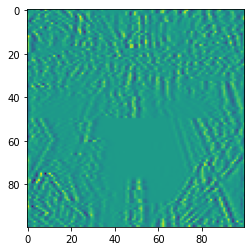

In [33]:
# broken_image는 랭크 1의 벡터로 이미지 행렬을 표현한 데이터
# 오염된 이미지를 텐서의 형태로 읽음
# 10,000개의 원소를 지닌 [100,100]모양의 행렬이 [10000]모양의 벡터로 표현된 형식
broken_image = torch.FloatTensor( pickle.load(open('/content/broken_image_t.p','rb'), encoding='latin1') )
# matplotlib 패키지를 이용해 [100,100]모양의 형식으로 바꾼 후 시각화
plt.imshow(broken_image.view(100,100))

weird_function() 함수의 코드는 이미지를 오염시키는 함수로 이해할 필요가 없다. 반대로 실행시키기 보다는 머신러닝을 이용하여 복원할 것이기 때문이다.

In [34]:
# weird_function 생성
def weird_function(x, n_iter=5):
    h = x
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat((zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0)
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 ==0:
            h = torch.cat( (h[h.shape[0]//2:], h[:h.shape[0]//2]), 0 )
    return h

다음으로 random_tensor를 weird_function() 함수에 입력해 얻은 hypothesis tensor와 broken_image 사이의 오차를 구하는 함수를 구현한다.

In [35]:
# torch.dist()는 두 텐서 사이의 거리를 구하는 함수
# 이번 예제에서는 이렇게 단순한 거리를 오찻값으로 설정
def distance_loss(hypothesis, broken_image):
    return torch.dist(hypothesis, broken_image)

다음으로 무작위 값을 가진 텐서를 생성한다. 이 텐서는 경사하강법을 통해 언젠가는 원본 이미지의 형상을 하게 될 것이다. 이 random_tensor 역시 broken_image와 같은 모양과 랭크를 지녀야 한다. 즉, [100,100]모양의 행렬이 [10000]모양의 벡터로 표현된 텐서이다.

In [36]:
# random_tensor 생성
random_tensor = torch.randn(10000, dtype=torch.float)

경사하강법은 여러 번 반복해서 이뤄진다. 이때 한 반복에서 최솟점으로 얼마나 많이 이동하는지, 즉 학습을 얼마나 급하게 진행하는가를 정하는 매개변수를 학습률(Learning rate)라고 한다. 이번 예제에서는 0.8로 설정한다.

학습률이 너무 크면 손실함수의 최솟점을 찾지 못하고 지나치게 되고, 값이 너무 작으면 학습 속도가 느려진다.

In [37]:
# 학습률 lr 설정
lr = 0.8

In [40]:
# 경사하강법 for 반복문 구현
# 손실함수를 random_tensor로 미분하기 위해 requires_grad=True로 설정
for i in range(0,20000):
    random_tensor.requires_grad_(True)
    # random_tensor를 weird_function() 함수에 통과시켜 hypothesis를 구함
    hypothesis = weird_function(random_tensor)
    # loss 계산 후 loss를 random_tensor로 미분
    loss = distance_loss(hypothesis, broken_image)
    loss.backward()
    # 자동 기울기 계산 비활성화
    with torch.no_grad():
        # random_tensor.grad에는 loss.backward() 함수에서 계산한 loss의 기울기가 들어있음
        # loss가 최댓값이 되는 곳의 방향이 들어있으므로 반대쪽으로 random_tensor를 lr만큼 이동시킴
        random_tensor = random_tensor - lr*random_tensor.grad
    # for문이 1,000번 반복될 때마다 오차를 출력
    if i%1000 == 0:
        print('Loss at{} = {}'. format(i, loss.item()))

Loss at0 = 12.4025239944458
Loss at1000 = 1.1531413793563843
Loss at2000 = 0.5516027808189392
Loss at3000 = 0.3785916566848755
Loss at4000 = 0.2976066768169403
Loss at5000 = 0.2486860156059265
Loss at6000 = 0.21389110386371613
Loss at7000 = 0.18645979464054108
Loss at8000 = 0.1633273810148239
Loss at9000 = 0.14290586113929749
Loss at10000 = 0.1242876872420311
Loss at11000 = 0.10691963136196136
Loss at12000 = 0.09044770896434784
Loss at13000 = 0.07463784515857697
Loss at14000 = 0.05933177471160889
Loss at15000 = 0.0444205179810524
Loss at16000 = 0.029830507934093475
Loss at17000 = 0.021153589710593224
Loss at18000 = 0.021165691316127777
Loss at19000 = 0.021167166531085968


파이토치는 신경망 모델 속 변수들이 지나가는 길인 그래프를 생성한다.
이번 예제에서는 직접 경사하강법을 구현하기 때문에 torch.no_grad() 함수를 이용해 파이토치의 자동 기울기 계산을 비활성화해야 한다.

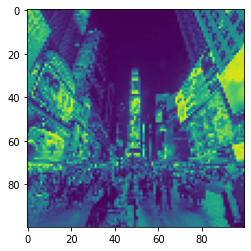

In [41]:
# 복원된 이미지를 확인
plt.imshow(random_tensor.view(100,100).data)